# Poor Population Impact Analysis

This notebook estimates the poor population impact by identifying the locations (cells) of the poorest people in each parish using Relative Wealth Index (RWI) data.

## Methodology

1. For each parish, the number of people living in poverty is known
2. Rank all cells by lowest RWI per parish
3. Starting from the lowest RWI, accumulate cells and their population until the poverty count for that parish is reached
4. This identifies the cells/locations of the poorest people


## Configuration

Set the paths and parameters here:


In [134]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration (optional - for calculating potentially impacted poor population)
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS (e.g., "000000" for midnight, "120000" for noon)
WIND_THRESHOLDS = ["34", "50", "64"]  # List of wind thresholds in knots to compare (e.g., ["34", "50", "64"])
STORM = "MELISSA"  # Storm name


# Total Jamaica population in 2018 from the Statistical Institute of Jamaica
# https://statinja.gov.jm/Demo_SocialStats/PopulationStats.aspx
TOTAL_POPULATION_2018 = 2_730_000

# Data from Table A3.1 - World Bank Jamaica Poverty Assessment 2018
# https://documents1.worldbank.org/curated/en/099103024132571700/pdf/P175282-4080b652-c512-4f34-a5ab-525c2c16f39d.pdf
# Poverty rate (%) and Population share (%) by parish
parish_data = {
    "Kingston": {"poverty_rate": 18.3, "population_share": 3.4},
    "Saint Andrew": {"poverty_rate": 10.9, "population_share": 21.2},
    "Saint Thomas": {"poverty_rate": 14.0, "population_share": 3.5},
    "Portland": {"poverty_rate": 12.2, "population_share": 3.1},
    "Saint Mary": {"poverty_rate": 12.3, "population_share": 4.2},
    "Saint Ann": {"poverty_rate": 20.9, "population_share": 6.4},
    "Trelawny": {"poverty_rate": 20.3, "population_share": 2.8},
    "Saint James": {"poverty_rate": 11.5, "population_share": 6.7},
    "Hanover": {"poverty_rate": 14.4, "population_share": 2.6},
    "Westmoreland": {"poverty_rate": 5.9, "population_share": 5.3},
    "Saint Elizabeth": {"poverty_rate": 18.7, "population_share": 5.6},
    "Manchester": {"poverty_rate": 9.2, "population_share": 7.1},
    "Clarendon": {"poverty_rate": 17.3, "population_share": 9.1},
    "Saint Catherine": {"poverty_rate": 9.0, "population_share": 19.0},
}

# Calculate absolute numbers
POVERTY_BY_PARISH = {}

for parish, data in parish_data.items():
    # Calculate parish population
    parish_population = TOTAL_POPULATION_2018 * (data["population_share"] / 100)

    # Calculate number of poor people in parish
    poor_population = parish_population * (data["poverty_rate"] / 100)

    # Round to nearest integer
    POVERTY_BY_PARISH[parish] = int(round(poor_population))

# Print results
print("# Poverty data per parish (in number of people)")
print("POVERTY_BY_PARISH = {")
for parish, poor_count in POVERTY_BY_PARISH.items():
    print(f'    "{parish}": {poor_count:,},')
print("}")


# Poverty data per parish (in number of people)
POVERTY_BY_PARISH = {
    "Kingston": 16,986,
    "Saint Andrew": 63,085,
    "Saint Thomas": 13,377,
    "Portland": 10,325,
    "Saint Mary": 14,103,
    "Saint Ann": 36,516,
    "Trelawny": 15,517,
    "Saint James": 21,035,
    "Hanover": 10,221,
    "Westmoreland": 8,537,
    "Saint Elizabeth": 28,589,
    "Manchester": 17,832,
    "Clarendon": 42,978,
    "Saint Catherine": 46,683,
}


## Import Libraries


In [135]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'


## Load Data Files


In [136]:
# Construct file paths
# Base admin boundaries file
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")

# Base tile file (14-level tiles with population and RWI)
tiles_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", f"{COUNTRY}_14.parquet")

print(f"Loading data files...")
print(f"  Admin boundaries: {admin_base_path}")
print(f"  Tiles: {tiles_base_path}")

# Load base admin boundaries
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
    print(f"   Columns: {list(gdf_admin.columns)}")
else:
    raise FileNotFoundError(f"Admin boundaries file not found: {admin_base_path}")

# Load base tiles with population and RWI
if os.path.exists(tiles_base_path):
    gdf_tiles = gpd.read_parquet(tiles_base_path)
    print(f"\nLoaded tiles: {len(gdf_tiles)} cells")
    print(f"   Columns: {list(gdf_tiles.columns)}")
else:
    raise FileNotFoundError(f"Tiles file not found: {tiles_base_path}")


Loading data files...
  Admin boundaries: data/geodb/aos_views/admin_views/JAM_admin1.parquet
  Tiles: data/geodb/aos_views/mercator_views/JAM_14.parquet

Loaded admin boundaries: 14 parishes
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'built_surface_m2', 'population', 'num_schools', 'num_hcs', 'smod_class', 'rwi', 'name', 'geometry']

Loaded tiles: 2231 cells
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id']


## Explore Data Structure


In [137]:
# Display admin boundaries info
print("=== ADMIN BOUNDARIES ===")
print(gdf_admin.head())
print(f"\nParish names:")
if 'name' in gdf_admin.columns:
    print(gdf_admin['name'].unique())
elif 'admin1' in gdf_admin.columns:
    print(gdf_admin['admin1'].unique())
elif 'NAME_1' in gdf_admin.columns:
    print(gdf_admin['NAME_1'].unique())

# Display tiles info
print("\n=== TILES DATA ===")
print(gdf_tiles.head())
print(f"\nAvailable columns with 'rwi' or 'pop':")
rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
pop_cols = [col for col in gdf_tiles.columns if 'pop' in col.lower()]
print(f"  RWI columns: {rwi_cols}")
print(f"  Population columns: {pop_cols}")


=== ADMIN BOUNDARIES ===
       tile_id  school_age_population  infant_population  built_surface_m2  \
0  JAM_0001_V2           61821.749270       21004.235492          22684229   
1  JAM_0002_V2           17270.302455        6671.824541           6108743   
2  JAM_0003_V2           43337.570937       14537.592760          21224362   
3  JAM_0004_V2           19141.140051        6014.671613           4679863   
4  JAM_0005_V2          120826.500507       38006.021894          34112127   

      population  num_schools  num_hcs  smod_class       rwi          name  \
0  285264.370281           53       11   12.428571  0.093685     Clarendon   
1   83475.957811           13        5   12.175000  0.158740       Hanover   
2  221986.978462           57       23   12.681250  0.196931    Manchester   
3   95390.115899           23       12   11.786550 -0.001749      Portland   
4  675523.895447          255       85   15.801075  0.458957  Saint Andrew   

                                     

## Prepare Data for Analysis


In [138]:
# Identify the correct column names
# Try to find RWI column
rwi_column = None
for col in gdf_tiles.columns:
    if col.lower() == 'rwi' or col.lower() == 'relative_wealth_index':
        rwi_column = col
        break

if rwi_column is None:
    # Try to find any column with 'rwi' in the name
    rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
    if rwi_cols:
        rwi_column = rwi_cols[0]

# Try to find population column
pop_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['population', 'pop', 'total_population']:
        pop_column = col
        break

if pop_column is None:
    # Try to find any column with 'pop' in the name
    pop_cols = [col for col in gdf_tiles.columns if 'pop' in col.lower()]
    if pop_cols:
        pop_column = pop_cols[0]

# Try to find tile_id column
tile_id_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['tile_id', 'tileid', 'id', 'zone_id']:
        tile_id_column = col
        break

print(f"Identified columns:")
print(f"  RWI column: {rwi_column}")
print(f"  Population column: {pop_column}")
print(f"  Tile ID column: {tile_id_column}")

if rwi_column is None or pop_column is None:
    print("\nWarning: Could not find RWI or population columns")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required columns (RWI and population) not found")

# Create a working copy of tiles
gdf_work = gdf_tiles.copy()

# Ensure we have the necessary columns with standardized names
gdf_work['rwi'] = gdf_work[rwi_column]
gdf_work['population'] = gdf_work[pop_column].fillna(0)
if tile_id_column:
    gdf_work['tile_id'] = gdf_work[tile_id_column]
else:
    gdf_work['tile_id'] = gdf_work.index

# Remove rows with missing RWI or zero population
gdf_work = gdf_work[gdf_work['rwi'].notna() & (gdf_work['population'] > 0)].copy()

print(f"\nPrepared {len(gdf_work)} tiles with valid RWI and population data")


Identified columns:
  RWI column: rwi
  Population column: population
  Tile ID column: tile_id

Prepared 2224 tiles with valid RWI and population data


## Spatial Join: Assign Tiles to Parishes


In [139]:
# Perform spatial join to assign each tile to a parish
# Ensure both GeoDataFrames have the same CRS
if gdf_work.crs != gdf_admin.crs:
    gdf_work = gdf_work.to_crs(gdf_admin.crs)

# Before spatial join, rename admin columns to avoid conflicts
# Keep only the name column from admin, rename others
admin_cols_to_keep = ['name', 'geometry']
gdf_admin_for_join = gdf_admin[admin_cols_to_keep].copy()

# Spatial join: tiles within or intersecting parishes
# Using 'intersects' instead of 'within' to catch tiles on boundaries (especially for small parishes like Kingston)
gdf_tiles_with_admin = gpd.sjoin(gdf_work, gdf_admin_for_join, how='left', predicate='intersects')

# Identify the parish name column (should be 'name' from the join)
parish_column = None
for col in ['name', 'admin1', 'NAME_1', 'ADMIN1', 'parish', 'Parish']:
    if col in gdf_tiles_with_admin.columns:
        parish_column = col
        break

if parish_column is None:
    print("Available columns:", list(gdf_tiles_with_admin.columns))
    raise ValueError("Could not find parish name column")

gdf_tiles_with_admin['parish'] = gdf_tiles_with_admin[parish_column]

# Remove tiles that don't fall within any parish
gdf_tiles_with_admin = gdf_tiles_with_admin[gdf_tiles_with_admin['parish'].notna()].copy()

# Handle potential duplicates from intersects (a tile might intersect multiple parishes)
# For tiles that intersect multiple parishes, assign to the parish that contains the tile's centroid
# This ensures each tile belongs to exactly ONE parish
duplicate_count_before = gdf_tiles_with_admin.index.duplicated().sum()
if duplicate_count_before > 0:
    print(f"Found {duplicate_count_before} tiles that intersect multiple parishes")
    print("   Resolving by assigning each tile to the parish containing its centroid...")
    
    # Get duplicate indices (tiles that appear multiple times)
    duplicate_indices = gdf_tiles_with_admin.index[gdf_tiles_with_admin.index.duplicated(keep=False)].unique()
    print(f"   {len(duplicate_indices)} tiles need resolution")
    
    # For each duplicate, find which parish contains its centroid
    tiles_to_remove = []
    for tile_idx in duplicate_indices:
        duplicates = gdf_tiles_with_admin.loc[[tile_idx]]
        if len(duplicates) > 1:
            # Get the tile geometry
            tile_geom = duplicates.iloc[0].geometry
            centroid = tile_geom.centroid
            
            # Check which parish contains the centroid
            centroid_gdf = gpd.GeoDataFrame([{'geometry': centroid}], crs=gdf_admin.crs)
            centroid_join = gpd.sjoin(centroid_gdf, gdf_admin[['name', 'geometry']], how='left', predicate='within')
            
            if len(centroid_join) > 0 and centroid_join['name'].iloc[0] is not None:
                # Keep only the row with the parish that contains the centroid
                correct_parish = centroid_join['name'].iloc[0]
                # Mark rows to remove (all except the one with correct_parish)
                rows_to_remove = gdf_tiles_with_admin.loc[
                    (gdf_tiles_with_admin.index == tile_idx) & 
                    (gdf_tiles_with_admin['parish'] != correct_parish)
                ]
                tiles_to_remove.extend(rows_to_remove.index.tolist())
            else:
                # If centroid is not in any parish (edge case), keep the first match
                rows_to_remove = gdf_tiles_with_admin.loc[[tile_idx]].iloc[1:]
                tiles_to_remove.extend(rows_to_remove.index.tolist())
    
    # Remove duplicate rows
    if tiles_to_remove:
        gdf_tiles_with_admin = gdf_tiles_with_admin.drop(tiles_to_remove)
        print(f"   Removed {len(tiles_to_remove)} duplicate assignments")
    
    # Verify no duplicates remain
    if gdf_tiles_with_admin.index.duplicated().any():
        remaining_duplicates = gdf_tiles_with_admin.index.duplicated().sum()
        print(f"   {remaining_duplicates} duplicates still remain, removing (keeping first)...")
        gdf_tiles_with_admin = gdf_tiles_with_admin[~gdf_tiles_with_admin.index.duplicated(keep='first')]
    
    print(f"   Each tile now belongs to exactly one parish")
else:
    print("No duplicate tile assignments found - each tile belongs to one parish")

# Ensure required columns (rwi and population should be from gdf_work, not duplicated)
# Check if columns exist
if 'rwi' not in gdf_tiles_with_admin.columns:
    # Try to find it with a suffix
    rwi_cols = [col for col in gdf_tiles_with_admin.columns if 'rwi' in col.lower()]
    if rwi_cols:
        gdf_tiles_with_admin['rwi'] = gdf_tiles_with_admin[rwi_cols[0]]
    else:
        raise ValueError("RWI column not found after spatial join")

if 'population' not in gdf_tiles_with_admin.columns:
    # Try to find it with a suffix
    pop_cols = [col for col in gdf_tiles_with_admin.columns if 'pop' in col.lower() and 'population' in col.lower()]
    if pop_cols:
        gdf_tiles_with_admin['population'] = gdf_tiles_with_admin[pop_cols[0]]
    else:
        raise ValueError("Population column not found after spatial join")

print(f"Assigned {len(gdf_tiles_with_admin)} tiles to parishes")
print(f"\nParishes found:")
print(gdf_tiles_with_admin['parish'].value_counts().sort_index())

# Show which parishes from POVERTY_BY_PARISH have tiles
print(f"\nParishes in poverty data vs tiles found:")
for parish in POVERTY_BY_PARISH.keys():
    tile_count = len(gdf_tiles_with_admin[gdf_tiles_with_admin['parish'] == parish])
    status = "✅" if tile_count > 0 else "⚠️  NO TILES"
    print(f"  {status} {parish}: {tile_count} tiles")

# Verify required columns exist
print(f"\nRequired columns verified:")
print(f"   - rwi: {'rwi' in gdf_tiles_with_admin.columns}")
print(f"   - population: {'population' in gdf_tiles_with_admin.columns}")
print(f"   - parish: {'parish' in gdf_tiles_with_admin.columns}")

# Final verification: ensure each tile belongs to only one parish
print(f"\nFinal verification:")
print(f"   Total tiles assigned: {len(gdf_tiles_with_admin)}")
print(f"   Unique tiles: {gdf_tiles_with_admin.index.nunique()}")
if len(gdf_tiles_with_admin) == gdf_tiles_with_admin.index.nunique():
    print(f"   Each tile belongs to exactly one parish")
else:
    print(f"   Warning: Some tiles may still be assigned to multiple parishes")


Found 325 tiles that intersect multiple parishes
   Resolving by assigning each tile to the parish containing its centroid...
   309 tiles need resolution
   Removed 332 duplicate assignments
   Each tile now belongs to exactly one parish
Assigned 1912 tiles to parishes

Parishes found:
parish
Clarendon          212
Hanover             76
Kingston             2
Manchester         129
Portland           147
Saint Andrew        70
Saint Ann          213
Saint Catherine    208
Saint Elizabeth    210
Saint James        101
Saint Mary         108
Saint Thomas       139
Trelawny           151
Westmoreland       146
Name: count, dtype: int64

Parishes in poverty data vs tiles found:
  ✅ Kingston: 2 tiles
  ✅ Saint Andrew: 70 tiles
  ✅ Saint Thomas: 139 tiles
  ✅ Portland: 147 tiles
  ✅ Saint Mary: 108 tiles
  ✅ Saint Ann: 213 tiles
  ✅ Trelawny: 151 tiles
  ✅ Saint James: 101 tiles
  ✅ Hanover: 76 tiles
  ✅ Westmoreland: 146 tiles
  ✅ Saint Elizabeth: 210 tiles
  ✅ Manchester: 129 tiles
  ✅ C

## Implement Poor Population Identification Methodology


In [140]:
def identify_poorest_cells(gdf_tiles, poverty_by_parish, rwi_col='rwi', pop_col='population', parish_col='parish'):
    """
    Identify the cells containing the poorest people in each parish.
    
    Methodology:
    1. For each parish, rank cells by lowest RWI
    2. Starting from lowest RWI, accumulate cells and population until reaching poverty count
    3. Return the identified cells
    
    Parameters:
    -----------
    gdf_tiles : GeoDataFrame
        Tiles with RWI, population, and parish information
    poverty_by_parish : dict
        Dictionary mapping parish names to number of people in poverty
    rwi_col : str
        Column name for RWI values
    pop_col : str
        Column name for population values
    parish_col : str
        Column name for parish names
    
    Returns:
    --------
    GeoDataFrame with identified poorest cells, including a 'is_poorest' flag
    """
    
    # Create a copy to avoid modifying original
    gdf_result = gdf_tiles.copy()
    gdf_result['is_poorest'] = False
    
    # Store summary statistics
    summary_stats = []
    
    # Process each parish
    for parish_name, poverty_count in poverty_by_parish.items():
        # Get all tiles for this parish
        parish_tiles = gdf_result[gdf_result[parish_col] == parish_name].copy()
        
        if len(parish_tiles) == 0:
            print(f"No tiles found for parish: {parish_name}")
            continue
        
        # Sort by RWI (ascending - lowest RWI first)
        parish_tiles = parish_tiles.sort_values(by=rwi_col, ascending=True)
        
        # Accumulate population starting from lowest RWI
        cumulative_pop = 0
        selected_tiles = []
        
        for idx, row in parish_tiles.iterrows():
            tile_pop = row[pop_col]
            
            if cumulative_pop + tile_pop <= poverty_count:
                # Add this tile to the poorest set
                cumulative_pop += tile_pop
                selected_tiles.append(idx)
            else:
                # Reached or exceeded the poverty count
                # Optionally include partial tile if close to target
                remaining = poverty_count - cumulative_pop
                if remaining > 0 and tile_pop > 0:
                    # Include this tile (may slightly exceed target)
                    selected_tiles.append(idx)
                    cumulative_pop += tile_pop
                break
        
        # Mark selected tiles as poorest
        gdf_result.loc[selected_tiles, 'is_poorest'] = True
        
        # Calculate statistics
        selected_tiles_gdf = gdf_result.loc[selected_tiles]
        avg_rwi = selected_tiles_gdf[rwi_col].mean() if len(selected_tiles) > 0 else None
        min_rwi = selected_tiles_gdf[rwi_col].min() if len(selected_tiles) > 0 else None
        max_rwi = selected_tiles_gdf[rwi_col].max() if len(selected_tiles) > 0 else None
        
        summary_stats.append({
            'parish': parish_name,
            'poverty_target': poverty_count,
            'cells_selected': len(selected_tiles),
            'population_covered': cumulative_pop,
            'coverage_pct': (cumulative_pop / poverty_count * 100) if poverty_count > 0 else 0,
            'avg_rwi': avg_rwi,
            'min_rwi': min_rwi,
            'max_rwi': max_rwi,
            'total_tiles_in_parish': len(parish_tiles)
        })
        
        print(f"\n{parish_name}:")
        print(f"  Target poverty population: {poverty_count:,}")
        print(f"  Selected {len(selected_tiles)} cells covering {cumulative_pop:,.0f} people ({cumulative_pop/poverty_count*100:.1f}%)")
        print(f"  RWI range: {min_rwi:.2f} to {max_rwi:.2f} (avg: {avg_rwi:.2f})")
    
    return gdf_result, pd.DataFrame(summary_stats)

# Run the analysis
print("Identifying poorest cells per parish...")
print("=" * 60)
gdf_poorest, df_summary = identify_poorest_cells(
    gdf_tiles_with_admin,
    POVERTY_BY_PARISH,
    rwi_col='rwi',
    pop_col='population',
    parish_col='parish'
)

print("\n" + "=" * 60)
print(f"Total poorest cells identified: {gdf_poorest['is_poorest'].sum()}")


Identifying poorest cells per parish...

Kingston:
  Target poverty population: 16,986
  Selected 1 cells covering 23,714 people (139.6%)
  RWI range: 0.97 to 0.97 (avg: 0.97)

Saint Andrew:
  Target poverty population: 63,085
  Selected 37 cells covering 68,817 people (109.1%)
  RWI range: -0.68 to 0.52 (avg: 0.11)

Saint Thomas:
  Target poverty population: 13,377
  Selected 33 cells covering 13,701 people (102.4%)
  RWI range: -0.78 to -0.25 (avg: -0.47)

Portland:
  Target poverty population: 10,325
  Selected 28 cells covering 10,754 people (104.2%)
  RWI range: -0.78 to -0.32 (avg: -0.53)

Saint Mary:
  Target poverty population: 14,103
  Selected 27 cells covering 14,204 people (100.7%)
  RWI range: -0.76 to -0.34 (avg: -0.51)

Saint Ann:
  Target poverty population: 36,516
  Selected 100 cells covering 36,605 people (100.2%)
  RWI range: -0.70 to 0.00 (avg: -0.19)

Trelawny:
  Target poverty population: 15,517
  Selected 69 cells covering 15,586 people (100.4%)
  RWI range: -0.

## Calculate Potentially Impacted Poor Population

Load impact probability data and calculate the potentially impacted poor population (poor population × impact probability):


In [141]:
# Load impact probability data if configured
# Store impact data for multiple thresholds
impact_data_by_threshold = {}

if DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM:
    date_str = DATE.replace("-", "")
    forecast_datetime_str = f"{date_str}{FORECAST_TIME}"
    
    # Load data for each wind threshold
    for wind_threshold in WIND_THRESHOLDS:
        admin_impact_file = f"{COUNTRY}_{STORM}_{forecast_datetime_str}_{wind_threshold}_admin1.csv"
        admin_impact_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", admin_impact_file)
        
        if os.path.exists(admin_impact_path):
            print(f"Loading impact probability data for {wind_threshold}kt from: {admin_impact_path}")
            df_impact = pd.read_csv(admin_impact_path)
            
            # Ensure 'name' column for joining
            if 'name' in df_impact.columns and 'probability' in df_impact.columns:
                # Create a mapping of parish name to probability
                impact_prob = df_impact[['name', 'probability']].copy()
                impact_prob = impact_prob.rename(columns={'probability': f'impact_probability_{wind_threshold}kt'})
                impact_data_by_threshold[wind_threshold] = impact_prob
                print(f"  Loaded {len(impact_prob)} parishes")
            else:
                print(f"Impact data file missing 'name' or 'probability' column")
        else:
            print(f"Impact probability file not found: {admin_impact_path}")
    
    # Merge all impact probabilities to summary statistics
    if impact_data_by_threshold:
        # Start with the summary
        df_summary_with_impact = df_summary.copy()
        
        # Merge each threshold's impact probability (using 'name' column from impact data, 'parish' from summary)
        for wind_threshold, impact_prob in impact_data_by_threshold.items():
            # Merge on name (from impact data) to parish (from summary)
            df_summary_with_impact = df_summary_with_impact.merge(
                impact_prob, 
                left_on='parish', 
                right_on='name', 
                how='left'
            )
            # Drop the 'name' column from the merge
            if 'name' in df_summary_with_impact.columns:
                df_summary_with_impact = df_summary_with_impact.drop(columns=['name'])
            
            # Calculate potentially impacted poor population for this threshold
            prob_col = f'impact_probability_{wind_threshold}kt'
            impact_col = f'potentially_impacted_poor_pop_{wind_threshold}kt'
            df_summary_with_impact[impact_col] = (
                df_summary_with_impact['population_covered'] * df_summary_with_impact[prob_col]
            ).fillna(0).round(0).astype(int)
        
        df_summary = df_summary_with_impact
        
        # Calculate total potentially impacted for each threshold
        print(f"\nImpact probability data loaded and calculated for {len(impact_data_by_threshold)} threshold(s)")
        for wind_threshold in impact_data_by_threshold.keys():
            impact_col = f'potentially_impacted_poor_pop_{wind_threshold}kt'
            if impact_col in df_summary.columns:
                total = df_summary[impact_col].sum()
                print(f"   {wind_threshold}kt: Total potentially impacted poor population: {total:,.0f}")
    else:
        print("No impact probability data files found")
        df_summary['impact_probability'] = None
        df_summary['potentially_impacted_poor_pop'] = 0
else:
    print("Impact probability configuration not set (DATE, FORECAST_TIME, WIND_THRESHOLDS, STORM)")
    print("   Skipping impact probability calculation")
    df_summary['impact_probability'] = None
    df_summary['potentially_impacted_poor_pop'] = 0


Loading impact probability data for 34kt from: data/geodb/aos_views/admin_views/JAM_MELISSA_20251027000000_34_admin1.csv
  Loaded 14 parishes
Loading impact probability data for 50kt from: data/geodb/aos_views/admin_views/JAM_MELISSA_20251027000000_50_admin1.csv
  Loaded 14 parishes
Loading impact probability data for 64kt from: data/geodb/aos_views/admin_views/JAM_MELISSA_20251027000000_64_admin1.csv
  Loaded 14 parishes

Impact probability data loaded and calculated for 3 threshold(s)
   34kt: Total potentially impacted poor population: 122,889
   50kt: Total potentially impacted poor population: 11,805
   64kt: Total potentially impacted poor population: 2,747


## Per-Parish Visualizations

Create individual visualizations for each parish showing the poorest cells:


Creating visualizations for 14 parishes...


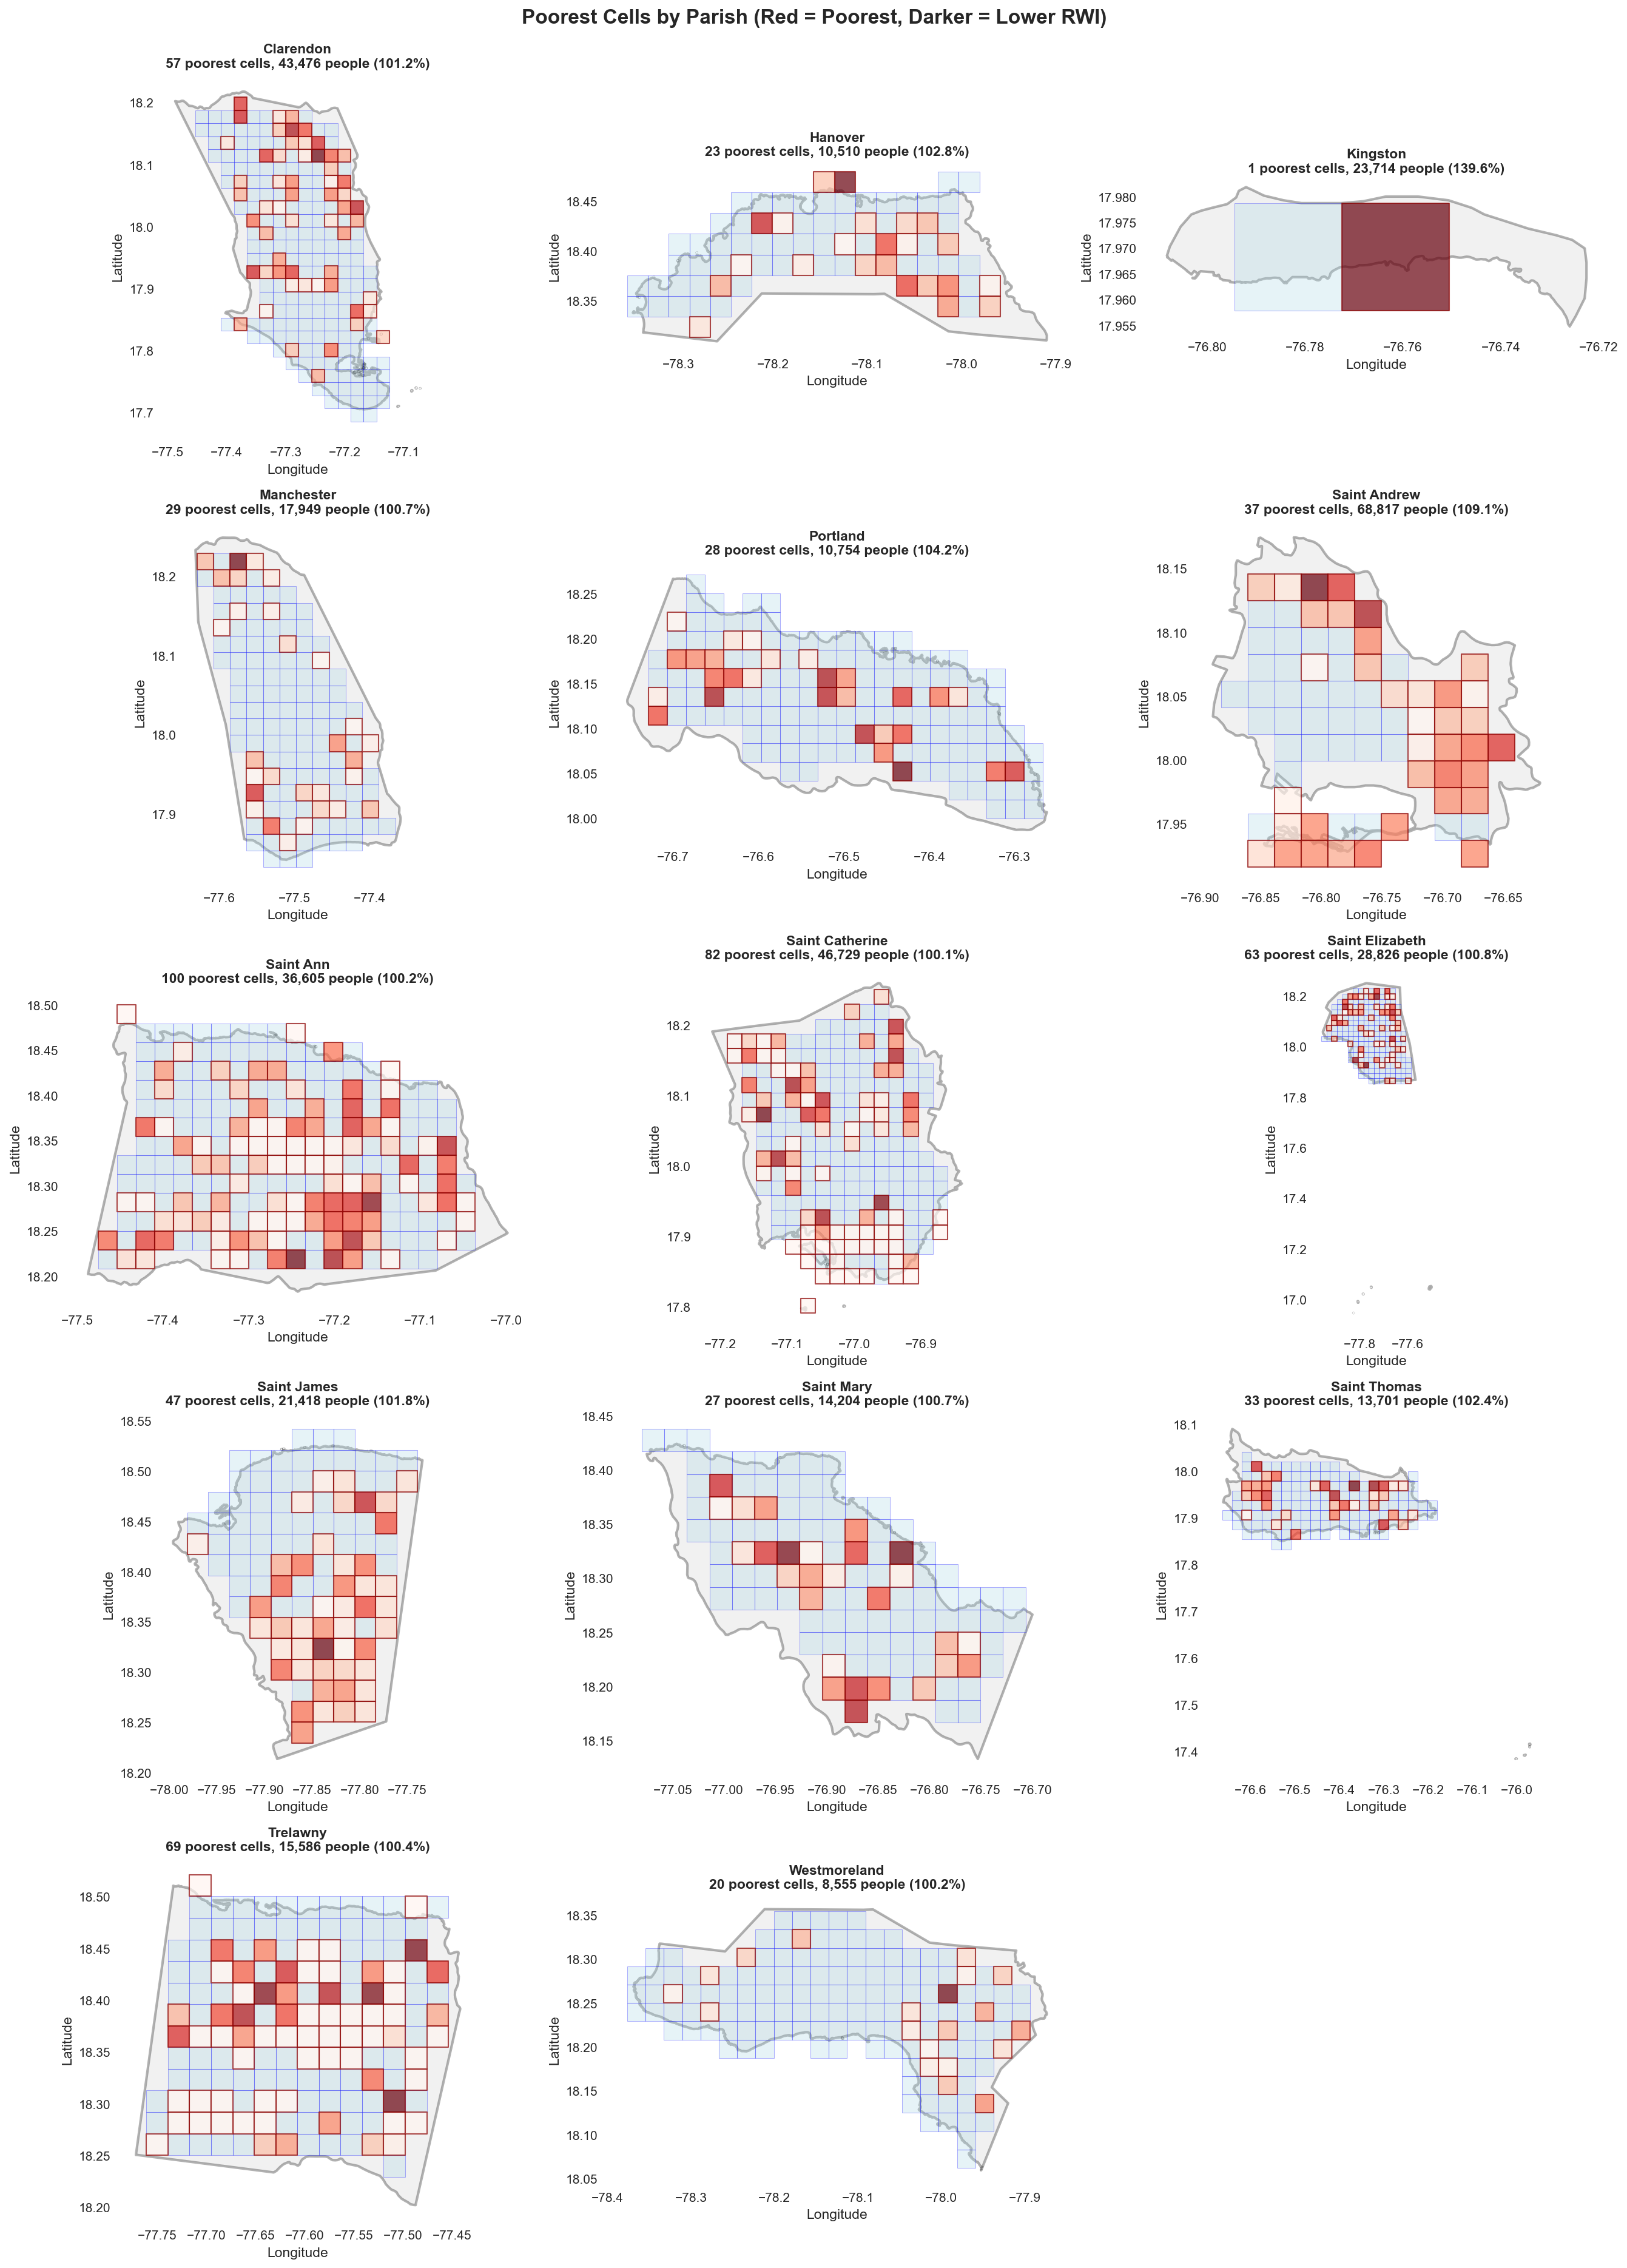

In [142]:
# Create individual visualizations for each parish
parishes_with_data = gdf_poorest[gdf_poorest['parish'].notna()]['parish'].unique()

# Filter to only parishes that have tiles
parishes_to_plot = [p for p in parishes_with_data if len(gdf_poorest[gdf_poorest['parish'] == p]) > 0]

print(f"Creating visualizations for {len(parishes_to_plot)} parishes...")
print("=" * 60)

# Calculate how many plots per row (3-4 parishes per row)
parishes_per_row = 3
n_rows = (len(parishes_to_plot) + parishes_per_row - 1) // parishes_per_row

# Create figure with subplots
fig, axes = plt.subplots(n_rows, parishes_per_row, figsize=(6*parishes_per_row, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif parishes_per_row == 1:
    axes = axes.reshape(-1, 1)

axes = axes.flatten()

for idx, parish_name in enumerate(sorted(parishes_to_plot)):
    ax = axes[idx]
    
    # Get parish admin boundary
    parish_admin = gdf_admin[gdf_admin['name'] == parish_name]
    
    # Get all tiles for this parish
    parish_all_tiles = gdf_poorest[gdf_poorest['parish'] == parish_name].copy()
    
    # Get poorest tiles
    parish_poorest = parish_all_tiles[parish_all_tiles['is_poorest']].copy()
    
    if len(parish_admin) > 0 and len(parish_all_tiles) > 0:
        # Plot parish boundary
        parish_admin.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2, alpha=0.3, label='Parish Boundary')
        
        # Plot all tiles (non-poorest) in light blue
        non_poorest = parish_all_tiles[~parish_all_tiles['is_poorest']]
        if len(non_poorest) > 0:
            non_poorest.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.3, linewidth=0.5, label='Other Tiles')
        
        # Plot poorest tiles in red
        if len(parish_poorest) > 0:
            # Color by RWI for poorest tiles (darker red = lower RWI = poorer)
            parish_poorest.plot(ax=ax, column='rwi', cmap='Reds_r', edgecolor='darkred', 
                               linewidth=1, alpha=0.7, legend=False, label='Poorest Cells', vmin=parish_poorest['rwi'].min(), vmax=parish_poorest['rwi'].max())
        
        # Add title with statistics
        if len(parish_poorest) > 0:
            pop_covered = parish_poorest['population'].sum()
            target = POVERTY_BY_PARISH.get(parish_name, 0)
            coverage_pct = (pop_covered / target * 100) if target > 0 else 0
            title = f"{parish_name}\n{len(parish_poorest)} poorest cells, {pop_covered:,.0f} people ({coverage_pct:.1f}%)"
        else:
            title = f"{parish_name}\nNo poorest cells identified"
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f"No data for\n{parish_name}", 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(parish_name, fontsize=11, fontweight='bold')

# Hide unused subplots
for idx in range(len(parishes_to_plot), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Poorest Cells by Parish (Red = Poorest, Darker = Lower RWI)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Methodology Demonstration

Detailed visualization showing how the poorest cells are selected for a single parish:


=== METHODOLOGY DEMONSTRATION: Saint Catherine ===
Poverty target: 46,683 people
Total tiles in parish: 208
Tiles selected (poorest): 82
Population covered: 46,729



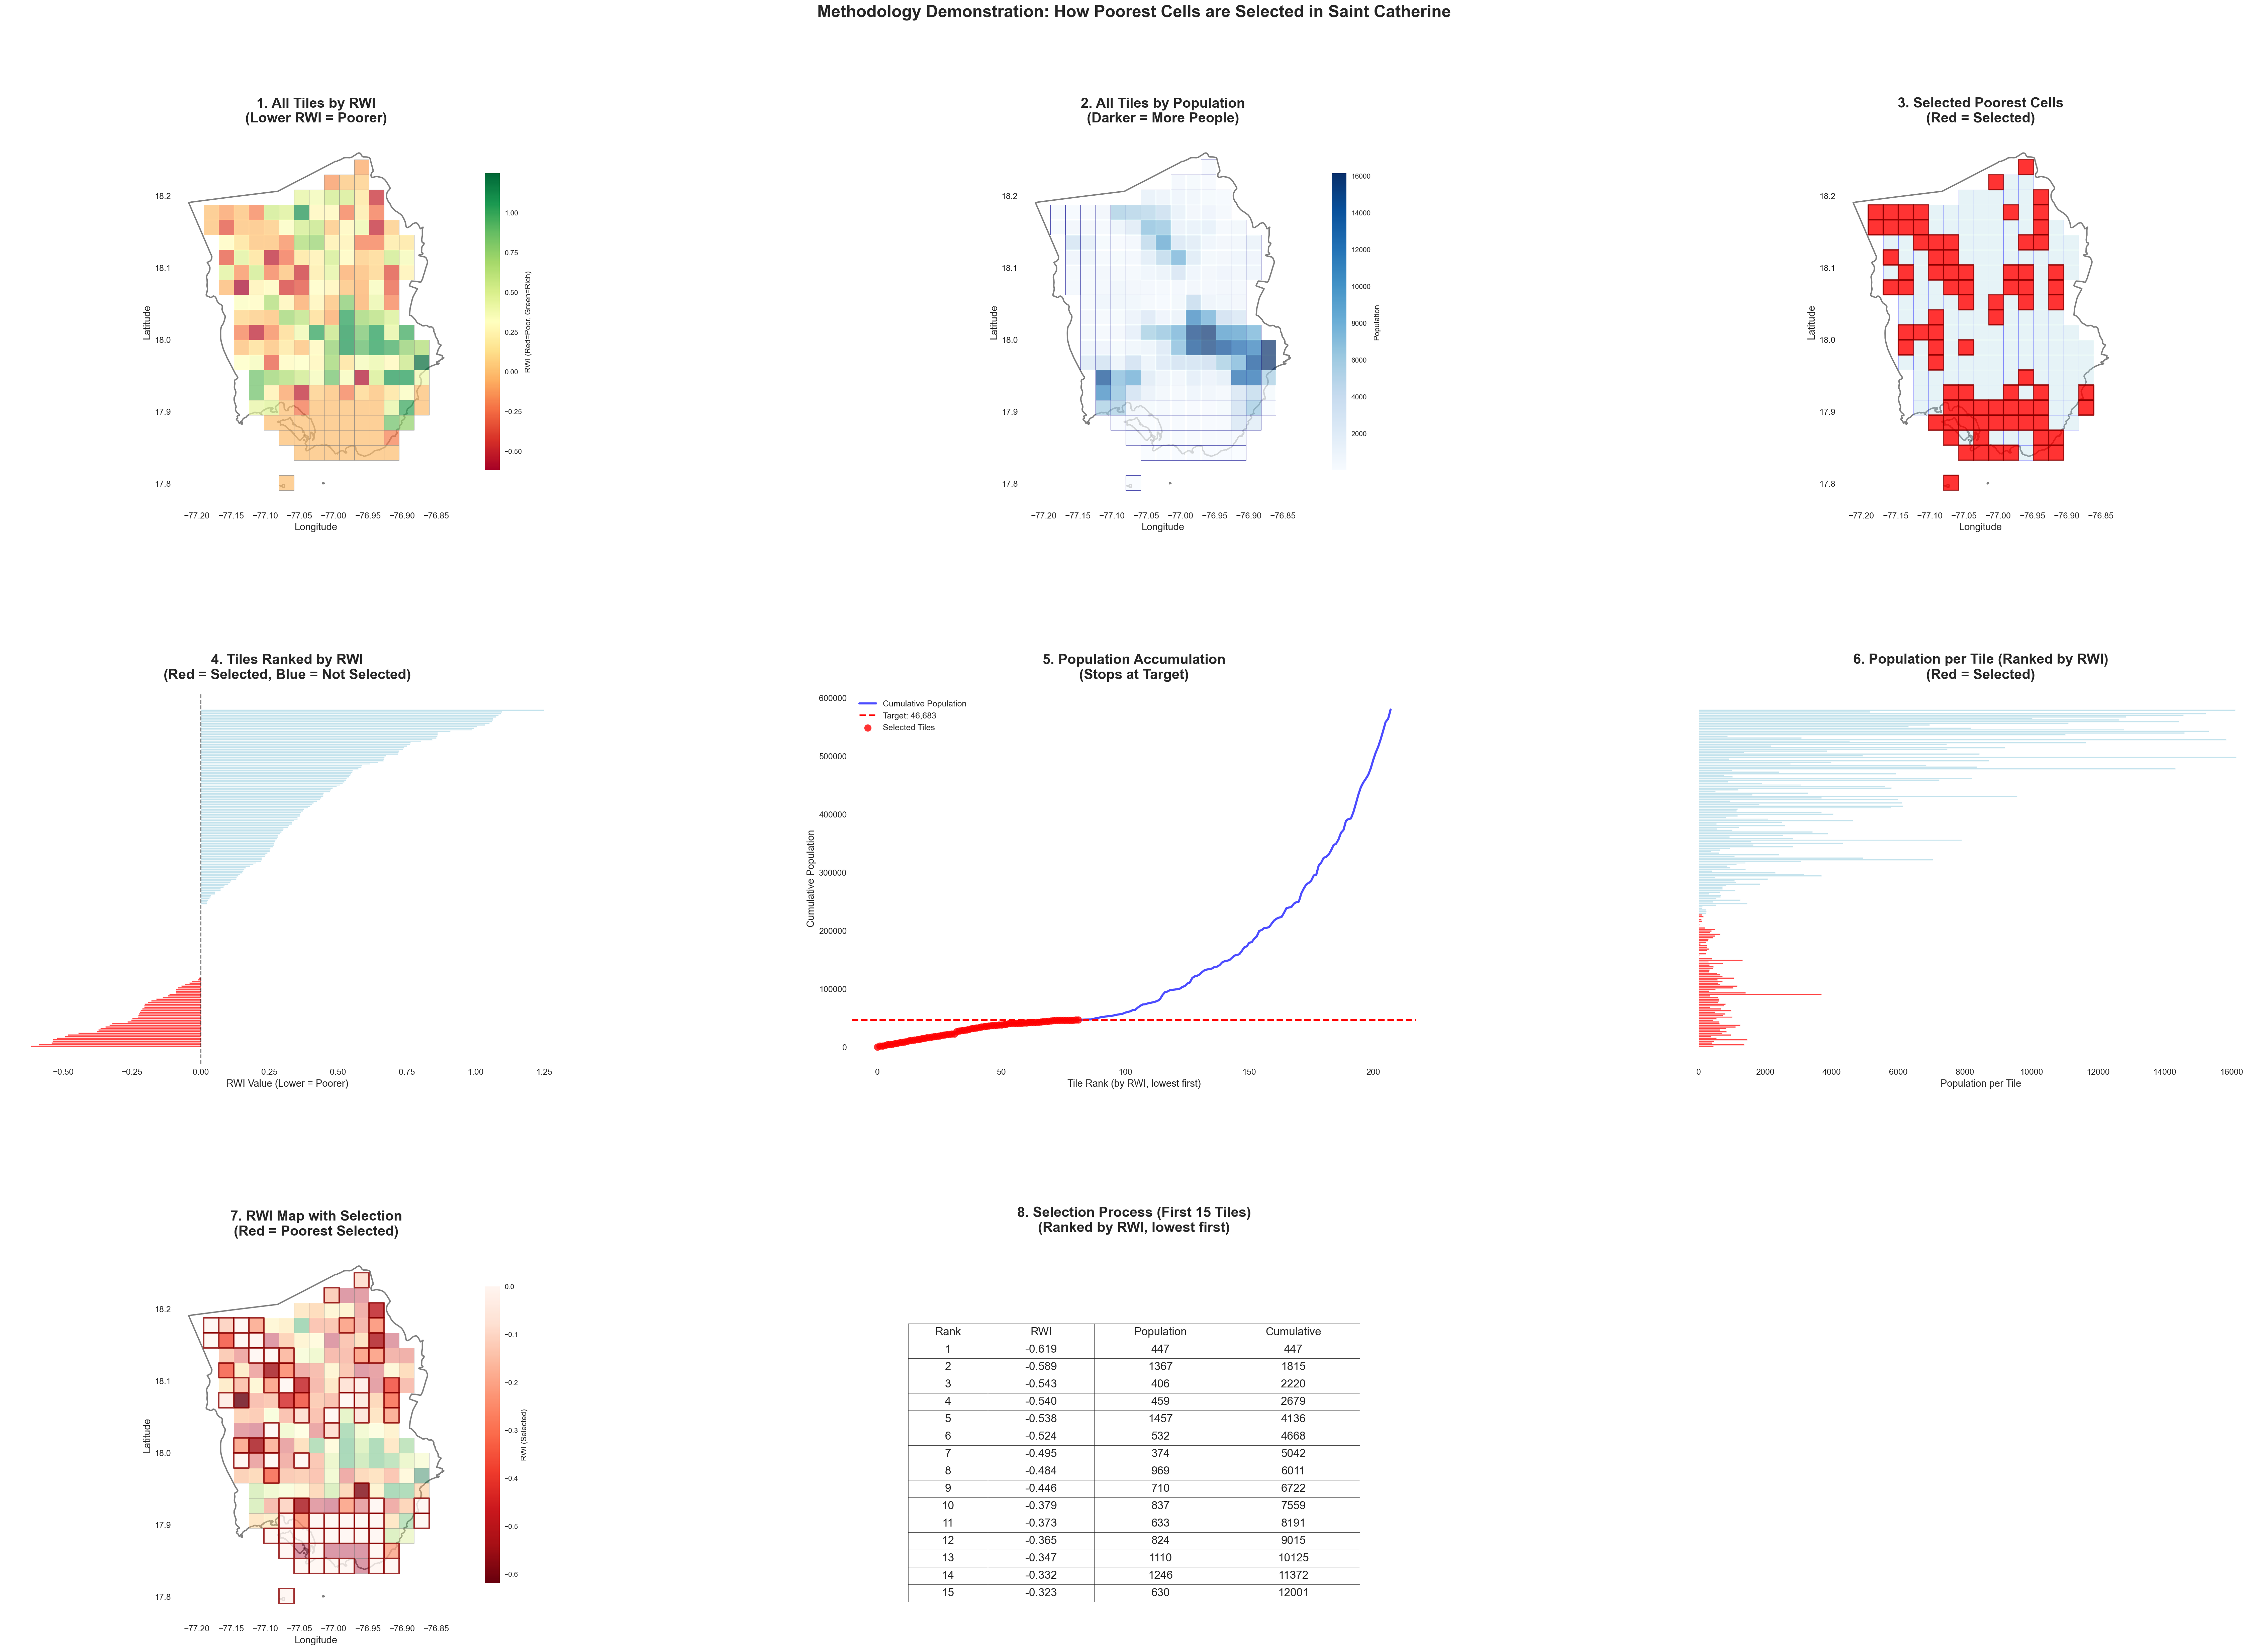

In [143]:
DEMO_PARISH = "Saint Catherine"

# Get data for the demo parish
parish_admin = gdf_admin[gdf_admin['name'] == DEMO_PARISH]
parish_tiles = gdf_poorest[gdf_poorest['parish'] == DEMO_PARISH].copy()

if len(parish_tiles) == 0:
    print(f"No tiles found for {DEMO_PARISH}")
    print(f"Available parishes: {sorted(gdf_poorest[gdf_poorest['parish'].notna()]['parish'].unique())}")
else:
    # Sort by RWI (ascending - lowest first)
    parish_tiles_sorted = parish_tiles.sort_values(by='rwi', ascending=True).copy()
    
    # Calculate cumulative population
    parish_tiles_sorted['cumulative_pop'] = parish_tiles_sorted['population'].cumsum()
    
    # Get poverty target
    poverty_target = POVERTY_BY_PARISH.get(DEMO_PARISH, 0)
    
    # Identify which tiles are selected (poorest)
    parish_tiles_sorted['is_selected'] = parish_tiles_sorted['is_poorest']
    
    # Find where the threshold is crossed
    threshold_crossed_idx = None
    for idx, row in parish_tiles_sorted.iterrows():
        if row['cumulative_pop'] >= poverty_target:
            threshold_crossed_idx = idx
            break
    
    print(f"=== METHODOLOGY DEMONSTRATION: {DEMO_PARISH} ===")
    print(f"Poverty target: {poverty_target:,} people")
    print(f"Total tiles in parish: {len(parish_tiles_sorted)}")
    print(f"Tiles selected (poorest): {parish_tiles_sorted['is_selected'].sum()}")
    print(f"Population covered: {parish_tiles_sorted[parish_tiles_sorted['is_selected']]['population'].sum():,.0f}")
    print()
    

    fig = plt.figure(figsize=(50, 34))
    gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.5, left=0.05, right=0.95, top=0.92, bottom=0.05)
    
    # 1. RWI Map (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    parish_admin.plot(ax=ax1, color='white', edgecolor='black', linewidth=2, alpha=0.5)
    parish_tiles_sorted.plot(ax=ax1, column='rwi', cmap='RdYlGn', 
                            edgecolor='gray', linewidth=0.5, alpha=0.7, legend=True,
                            legend_kwds={'label': 'RWI (Red=Poor, Green=Rich)', 'shrink': 0.8})
    ax1.set_title('1. All Tiles by RWI\n(Lower RWI = Poorer)', fontsize=20, fontweight='bold', pad=20)
    ax1.set_xlabel('Longitude', fontsize=14)
    ax1.set_ylabel('Latitude', fontsize=14)
    ax1.tick_params(labelsize=12)
    ax1.grid(True, alpha=0.3)
    
    # 2. Population Map (Top Middle)
    ax2 = fig.add_subplot(gs[0, 1])
    parish_admin.plot(ax=ax2, color='white', edgecolor='black', linewidth=2, alpha=0.5)
    parish_tiles_sorted.plot(ax=ax2, column='population', cmap='Blues', 
                            edgecolor='darkblue', linewidth=0.5, alpha=0.7, legend=True,
                            legend_kwds={'label': 'Population', 'shrink': 0.8})
    ax2.set_title('2. All Tiles by Population\n(Darker = More People)', fontsize=20, fontweight='bold', pad=20)
    ax2.set_xlabel('Longitude', fontsize=14)
    ax2.set_ylabel('Latitude', fontsize=14)
    ax2.tick_params(labelsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. Selection Result (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    parish_admin.plot(ax=ax3, color='white', edgecolor='black', linewidth=2, alpha=0.5)
    # Plot non-selected tiles
    non_selected = parish_tiles_sorted[~parish_tiles_sorted['is_selected']]
    if len(non_selected) > 0:
        non_selected.plot(ax=ax3, color='lightblue', edgecolor='blue', alpha=0.3, linewidth=0.5)
    # Plot selected tiles (poorest)
    selected = parish_tiles_sorted[parish_tiles_sorted['is_selected']]
    if len(selected) > 0:
        selected.plot(ax=ax3, color='red', edgecolor='darkred', linewidth=2, alpha=0.8, label='Poorest Cells')
    ax3.set_title('3. Selected Poorest Cells\n(Red = Selected)', fontsize=20, fontweight='bold', pad=20)
    ax3.set_xlabel('Longitude', fontsize=14)
    ax3.set_ylabel('Latitude', fontsize=14)
    ax3.tick_params(labelsize=12)
    ax3.legend(fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 4. RWI Ranking (Middle Left) - Bar chart showing RWI sorted
    ax4 = fig.add_subplot(gs[1, 0])
    # Create a bar chart of RWI values sorted
    sorted_rwi = parish_tiles_sorted['rwi'].values
    colors = ['red' if sel else 'lightblue' for sel in parish_tiles_sorted['is_selected'].values]
    ax4.barh(range(len(sorted_rwi)), sorted_rwi, color=colors, alpha=0.7)
    ax4.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax4.set_yticks([])
    ax4.set_xlabel('RWI Value (Lower = Poorer)', fontsize=14)
    ax4.set_title('4. Tiles Ranked by RWI\n(Red = Selected, Blue = Not Selected)', fontsize=20, fontweight='bold', pad=20)
    ax4.tick_params(labelsize=12)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 5. Cumulative Population (Middle) - Line chart showing accumulation
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(range(len(parish_tiles_sorted)), parish_tiles_sorted['cumulative_pop'].values, 
            'b-', linewidth=3, label='Cumulative Population', alpha=0.7)
    ax5.axhline(y=poverty_target, color='red', linestyle='--', linewidth=2.5, label=f'Target: {poverty_target:,}')
    
    # Highlight selected tiles
    selected_indices = [i for i, sel in enumerate(parish_tiles_sorted['is_selected'].values) if sel]
    if selected_indices:
        selected_cumulative = parish_tiles_sorted.iloc[selected_indices]['cumulative_pop'].values
        ax5.scatter(selected_indices, selected_cumulative, color='red', s=100, zorder=5, 
                   label='Selected Tiles', alpha=0.8)
    
    ax5.set_xlabel('Tile Rank (by RWI, lowest first)', fontsize=14)
    ax5.set_ylabel('Cumulative Population', fontsize=14)
    ax5.set_title('5. Population Accumulation\n(Stops at Target)', fontsize=20, fontweight='bold', pad=20)
    ax5.tick_params(labelsize=12)
    ax5.legend(fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # 6. Population per Tile (Middle Right) - Bar chart
    ax6 = fig.add_subplot(gs[1, 2])
    sorted_pop = parish_tiles_sorted['population'].values
    colors_pop = ['red' if sel else 'lightblue' for sel in parish_tiles_sorted['is_selected'].values]
    ax6.barh(range(len(sorted_pop)), sorted_pop, color=colors_pop, alpha=0.7)
    ax6.set_yticks([])
    ax6.set_xlabel('Population per Tile', fontsize=14)
    ax6.set_title('6. Population per Tile (Ranked by RWI)\n(Red = Selected)', fontsize=20, fontweight='bold', pad=20)
    ax6.tick_params(labelsize=12)
    ax6.grid(True, alpha=0.3, axis='x')
    
    # 7. Combined RWI + Population (Bottom Left)
    ax7 = fig.add_subplot(gs[2, 0])
    parish_admin.plot(ax=ax7, color='white', edgecolor='black', linewidth=2, alpha=0.5)
    # Color by RWI, size by population
    non_selected = parish_tiles_sorted[~parish_tiles_sorted['is_selected']]
    selected = parish_tiles_sorted[parish_tiles_sorted['is_selected']]
    
    if len(non_selected) > 0:
        non_selected.plot(ax=ax7, column='rwi', cmap='RdYlGn', 
                         edgecolor='gray', linewidth=0.5, alpha=0.4, legend=False)
    if len(selected) > 0:
        selected.plot(ax=ax7, column='rwi', cmap='Reds_r', 
                     edgecolor='darkred', linewidth=2, alpha=0.8, legend=True,
                     legend_kwds={'label': 'RWI (Selected)', 'shrink': 0.8})
    ax7.set_title('7. RWI Map with Selection\n(Red = Poorest Selected)', fontsize=20, fontweight='bold', pad=20)
    ax7.set_xlabel('Longitude', fontsize=14)
    ax7.set_ylabel('Latitude', fontsize=14)
    ax7.tick_params(labelsize=12)
    ax7.grid(True, alpha=0.3)
    
    # 8. Selection Process Table (Bottom Middle)
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.axis('off')
    
    # Set title first with proper padding
    ax8.set_title('8. Selection Process (First 15 Tiles)\n(Ranked by RWI, lowest first)', 
                 fontsize=20, fontweight='bold', pad=25)
    
    # Create a table showing the selection process
    table_data = []
    selected_tiles_data = parish_tiles_sorted[parish_tiles_sorted['is_selected']].head(10)
    
    table_data.append(['Rank', 'RWI', 'Population', 'Cumulative'])
    cum_pop = 0
    for rank, (idx, row) in enumerate(parish_tiles_sorted.head(15).iterrows(), 1):
        cum_pop += row['population']
        table_data.append([
            str(rank),
            f"{row['rwi']:.3f}",
            f"{row['population']:.0f}",
            f"{cum_pop:.0f}"
        ])
    
    # Position table below the title (lower y position)
    table = ax8.table(cellText=table_data, loc='center', cellLoc='center',
                      colWidths=[0.15, 0.2, 0.25, 0.25, 0.15],
                      bbox=[0.1, 0.05, 0.8, 0.75])  # [left, bottom, width, height] - lower bottom value
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1, 2.5)
    
    plt.suptitle(f'Methodology Demonstration: How Poorest Cells are Selected in {DEMO_PARISH}', 
                fontsize=24, fontweight='bold', y=0.997)
    plt.show()


## Summary Visualization


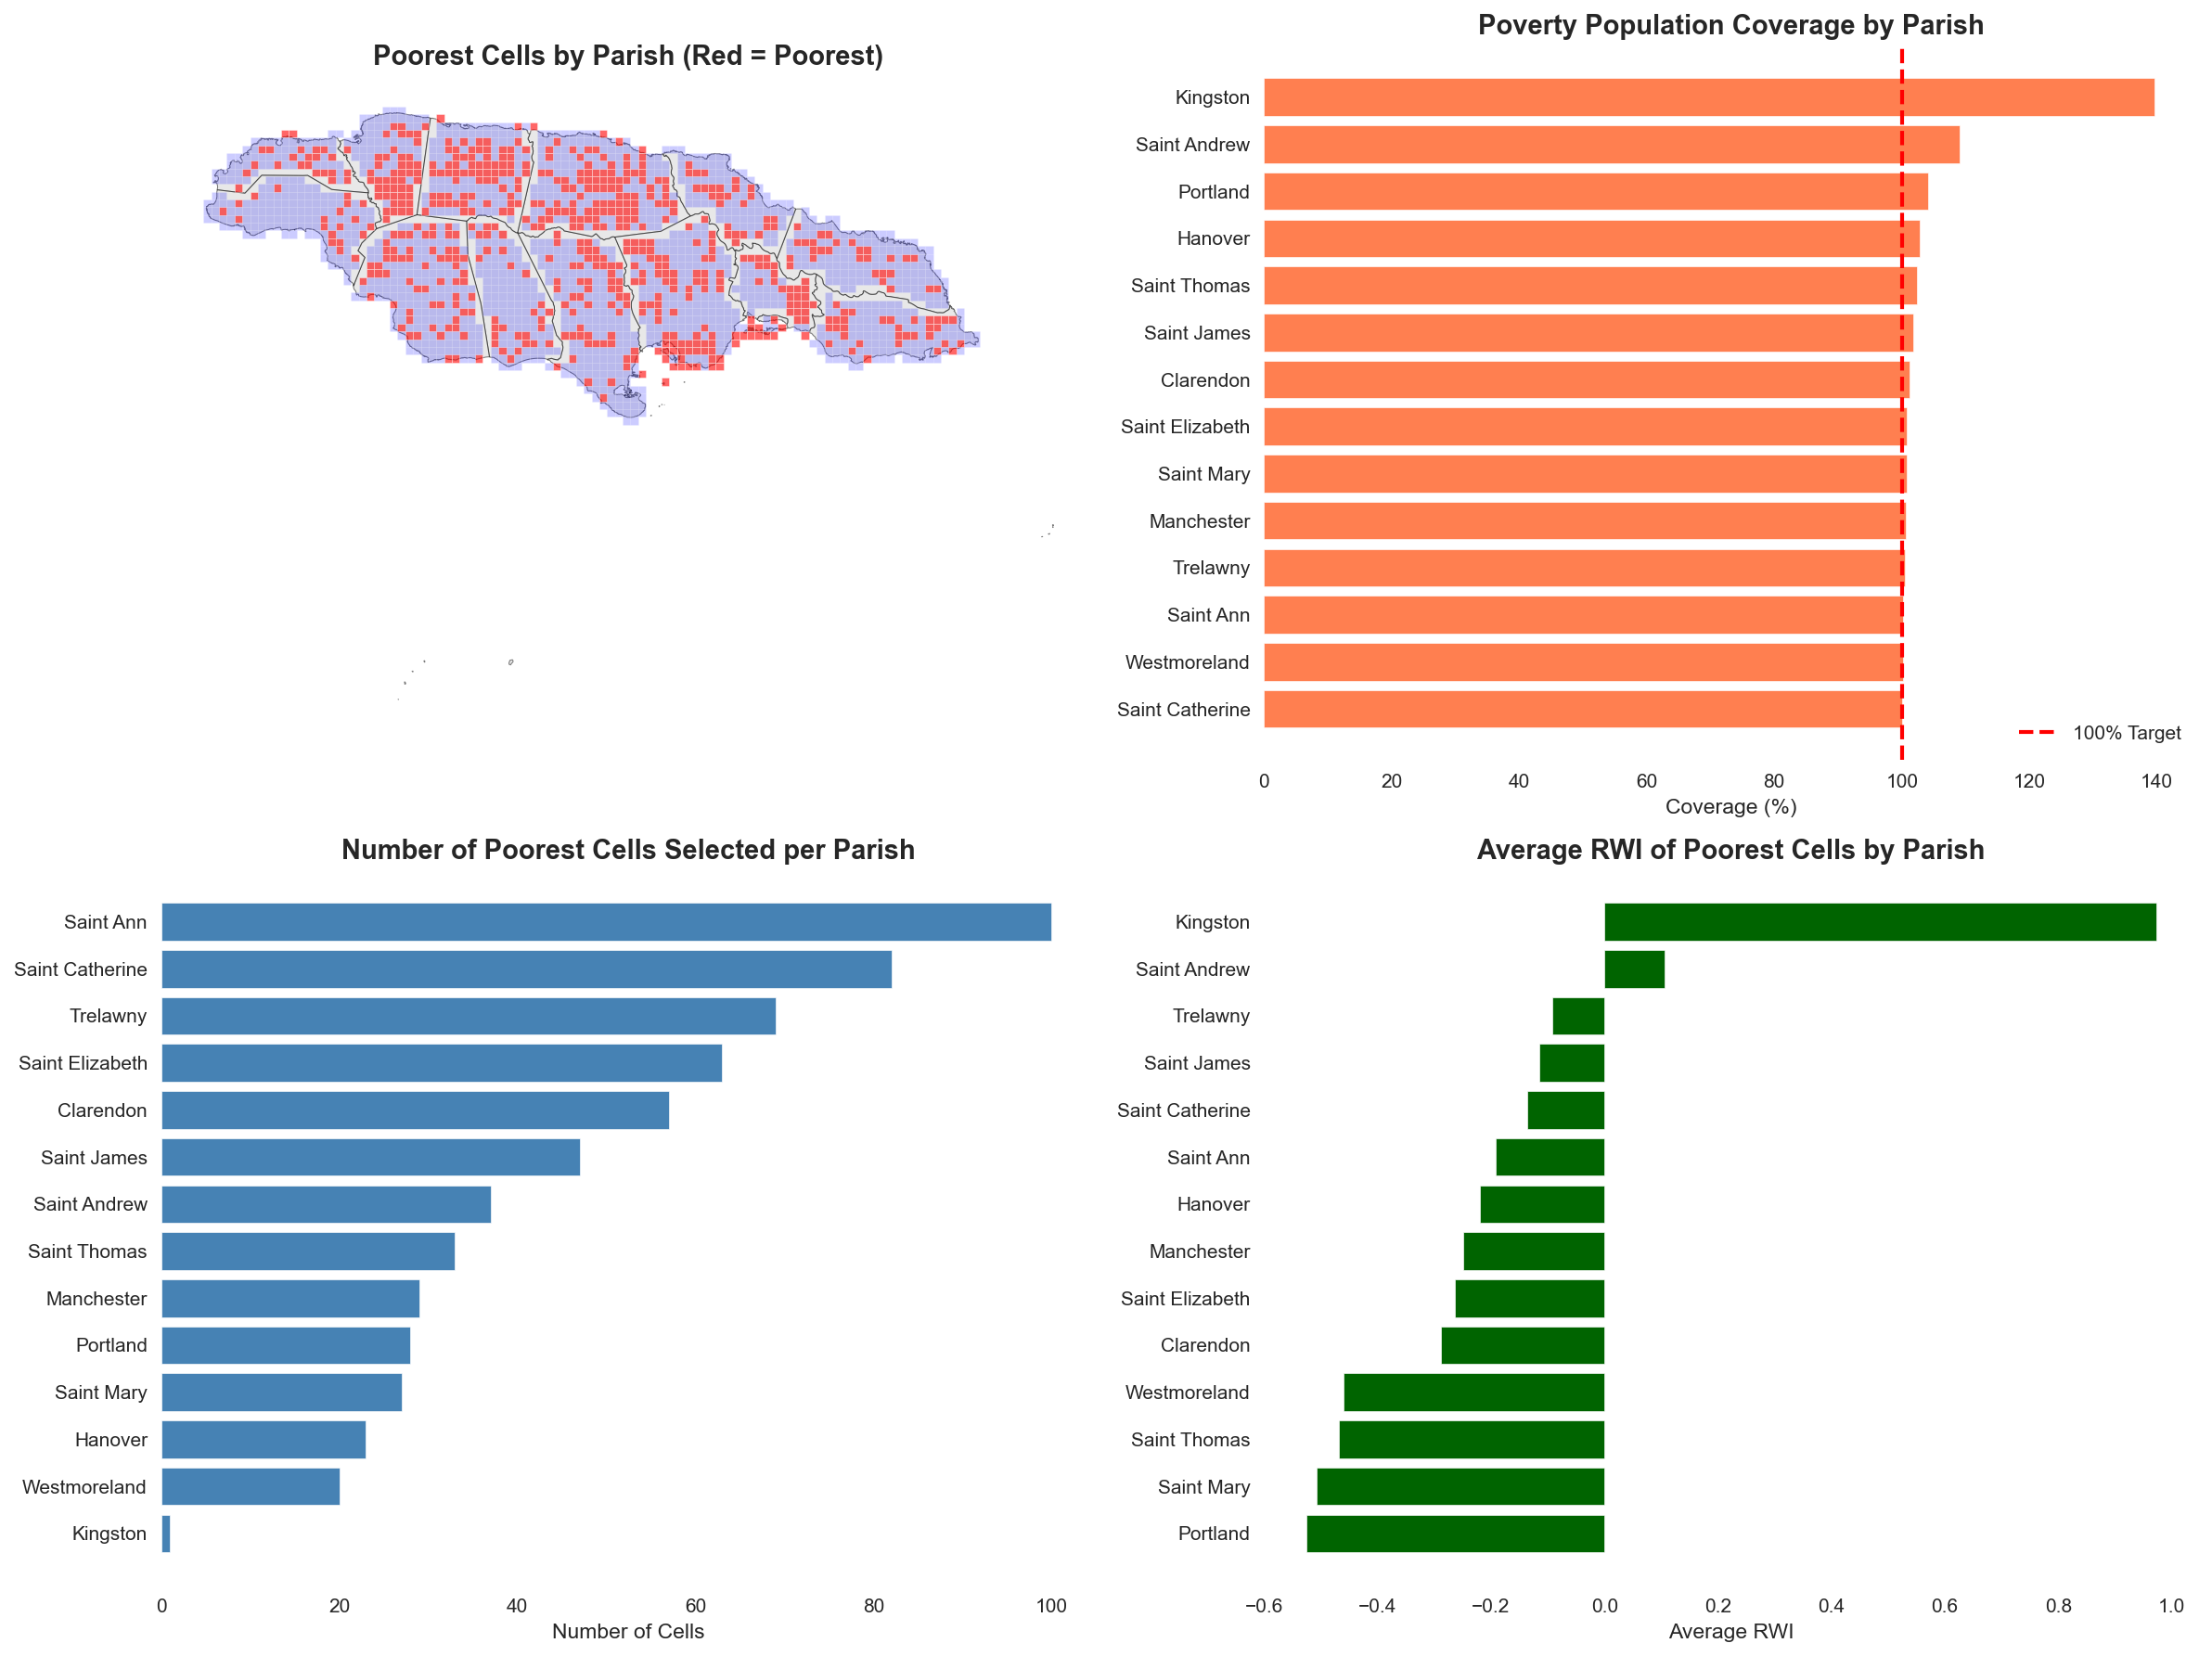

In [144]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Map of poorest cells
ax1 = axes[0, 0]
gdf_admin.plot(ax=ax1, color='lightgray', edgecolor='black', linewidth=0.5, alpha=0.5)
gdf_poorest[gdf_poorest['is_poorest']].plot(ax=ax1, color='red', alpha=0.6, markersize=1)
gdf_poorest[~gdf_poorest['is_poorest']].plot(ax=ax1, color='blue', alpha=0.2, markersize=0.5)
ax1.set_title('Poorest Cells by Parish (Red = Poorest)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.axis('off')

# 2. Coverage by parish
ax2 = axes[0, 1]
df_plot = df_summary.sort_values('coverage_pct', ascending=True)
ax2.barh(df_plot['parish'], df_plot['coverage_pct'], color='coral')
ax2.axvline(x=100, color='red', linestyle='--', linewidth=2, label='100% Target')
ax2.set_xlabel('Coverage (%)')
ax2.set_title('Poverty Population Coverage by Parish', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# 3. Number of cells selected per parish
ax3 = axes[1, 0]
df_plot2 = df_summary.sort_values('cells_selected', ascending=True)
ax3.barh(df_plot2['parish'], df_plot2['cells_selected'], color='steelblue')
ax3.set_xlabel('Number of Cells')
ax3.set_title('Number of Poorest Cells Selected per Parish', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Average RWI of poorest cells by parish
ax4 = axes[1, 1]
df_plot3 = df_summary.sort_values('avg_rwi', ascending=True)
ax4.barh(df_plot3['parish'], df_plot3['avg_rwi'], color='darkgreen')
ax4.set_xlabel('Average RWI')
ax4.set_title('Average RWI of Poorest Cells by Parish', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## Potentially Impacted Poor Population Visualization

Compare potentially impacted poor population across multiple wind thresholds:


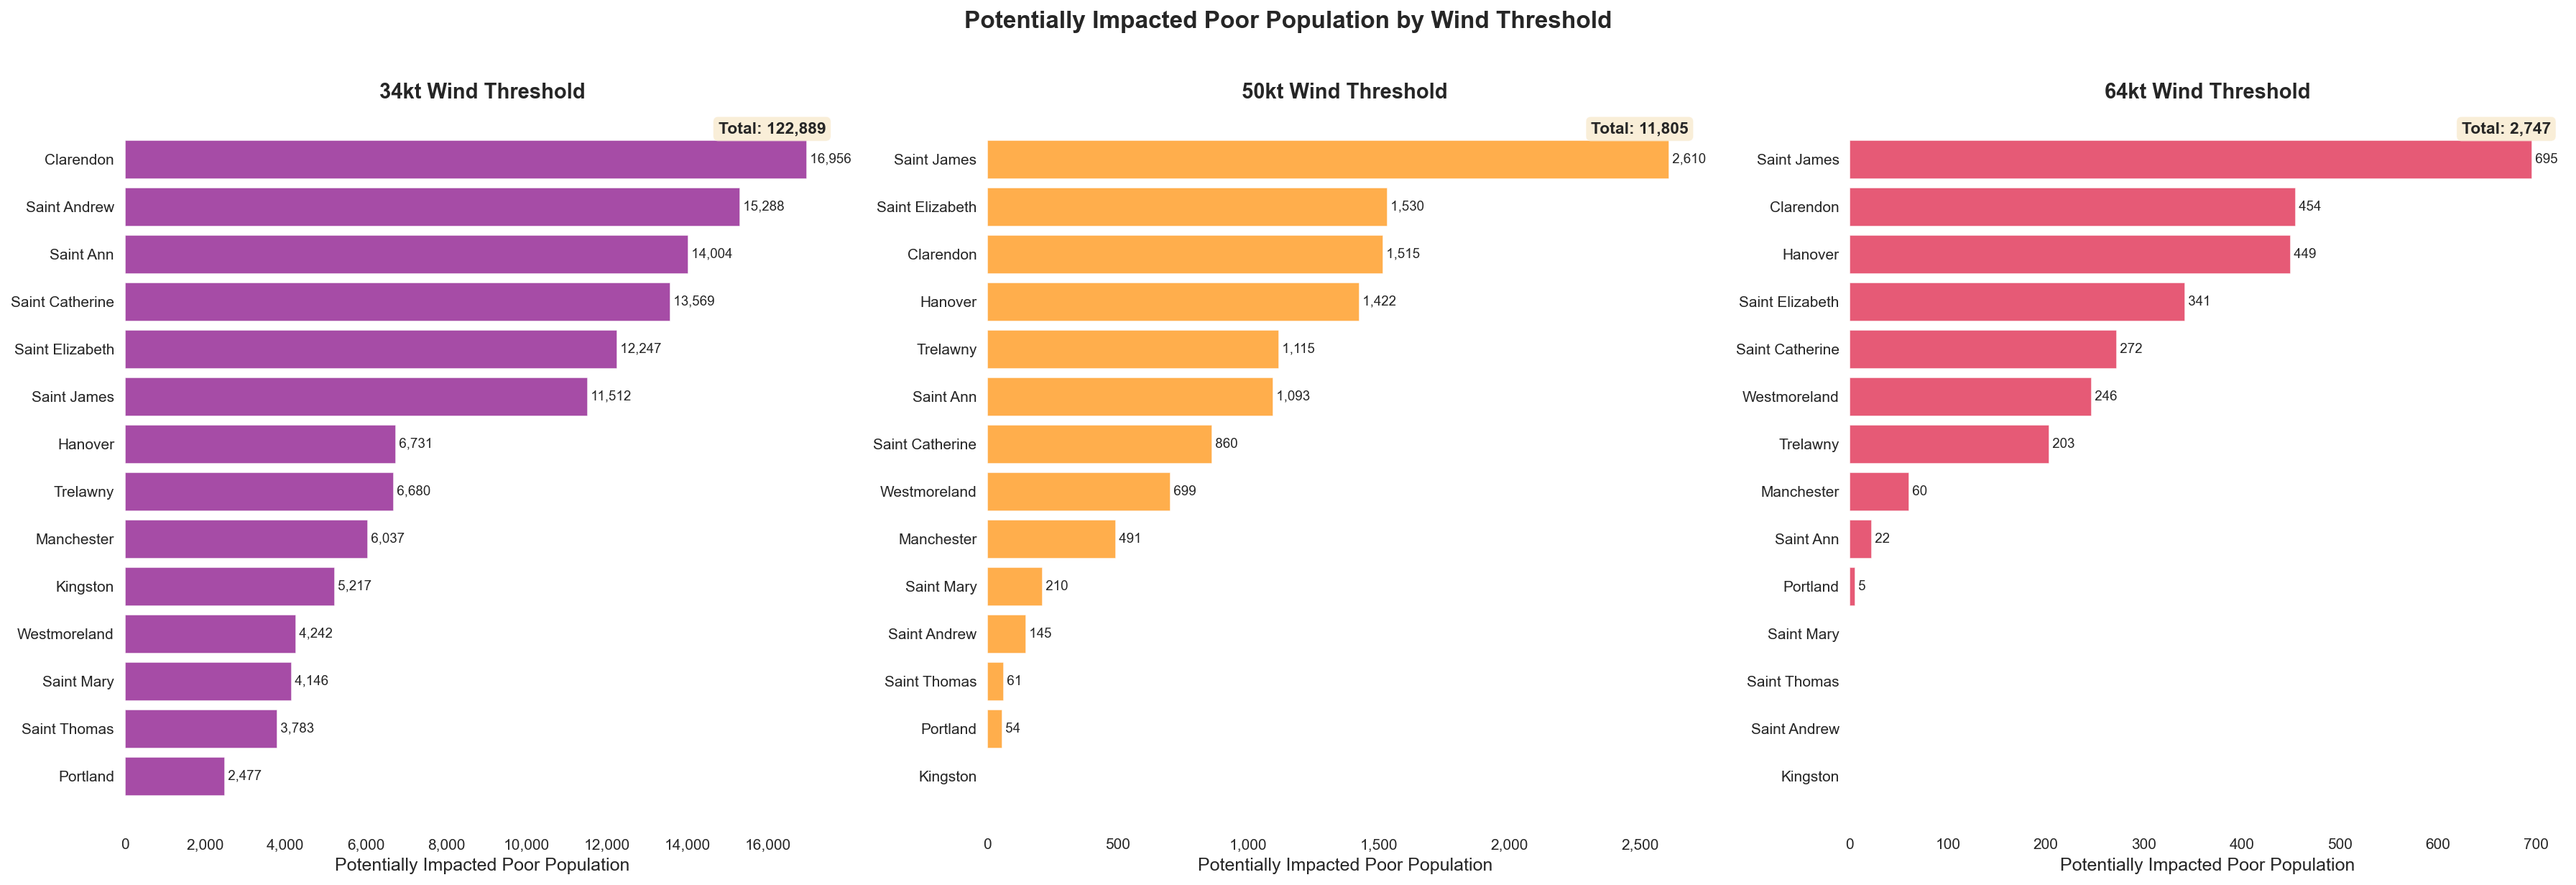


Creating side-by-side comparison...


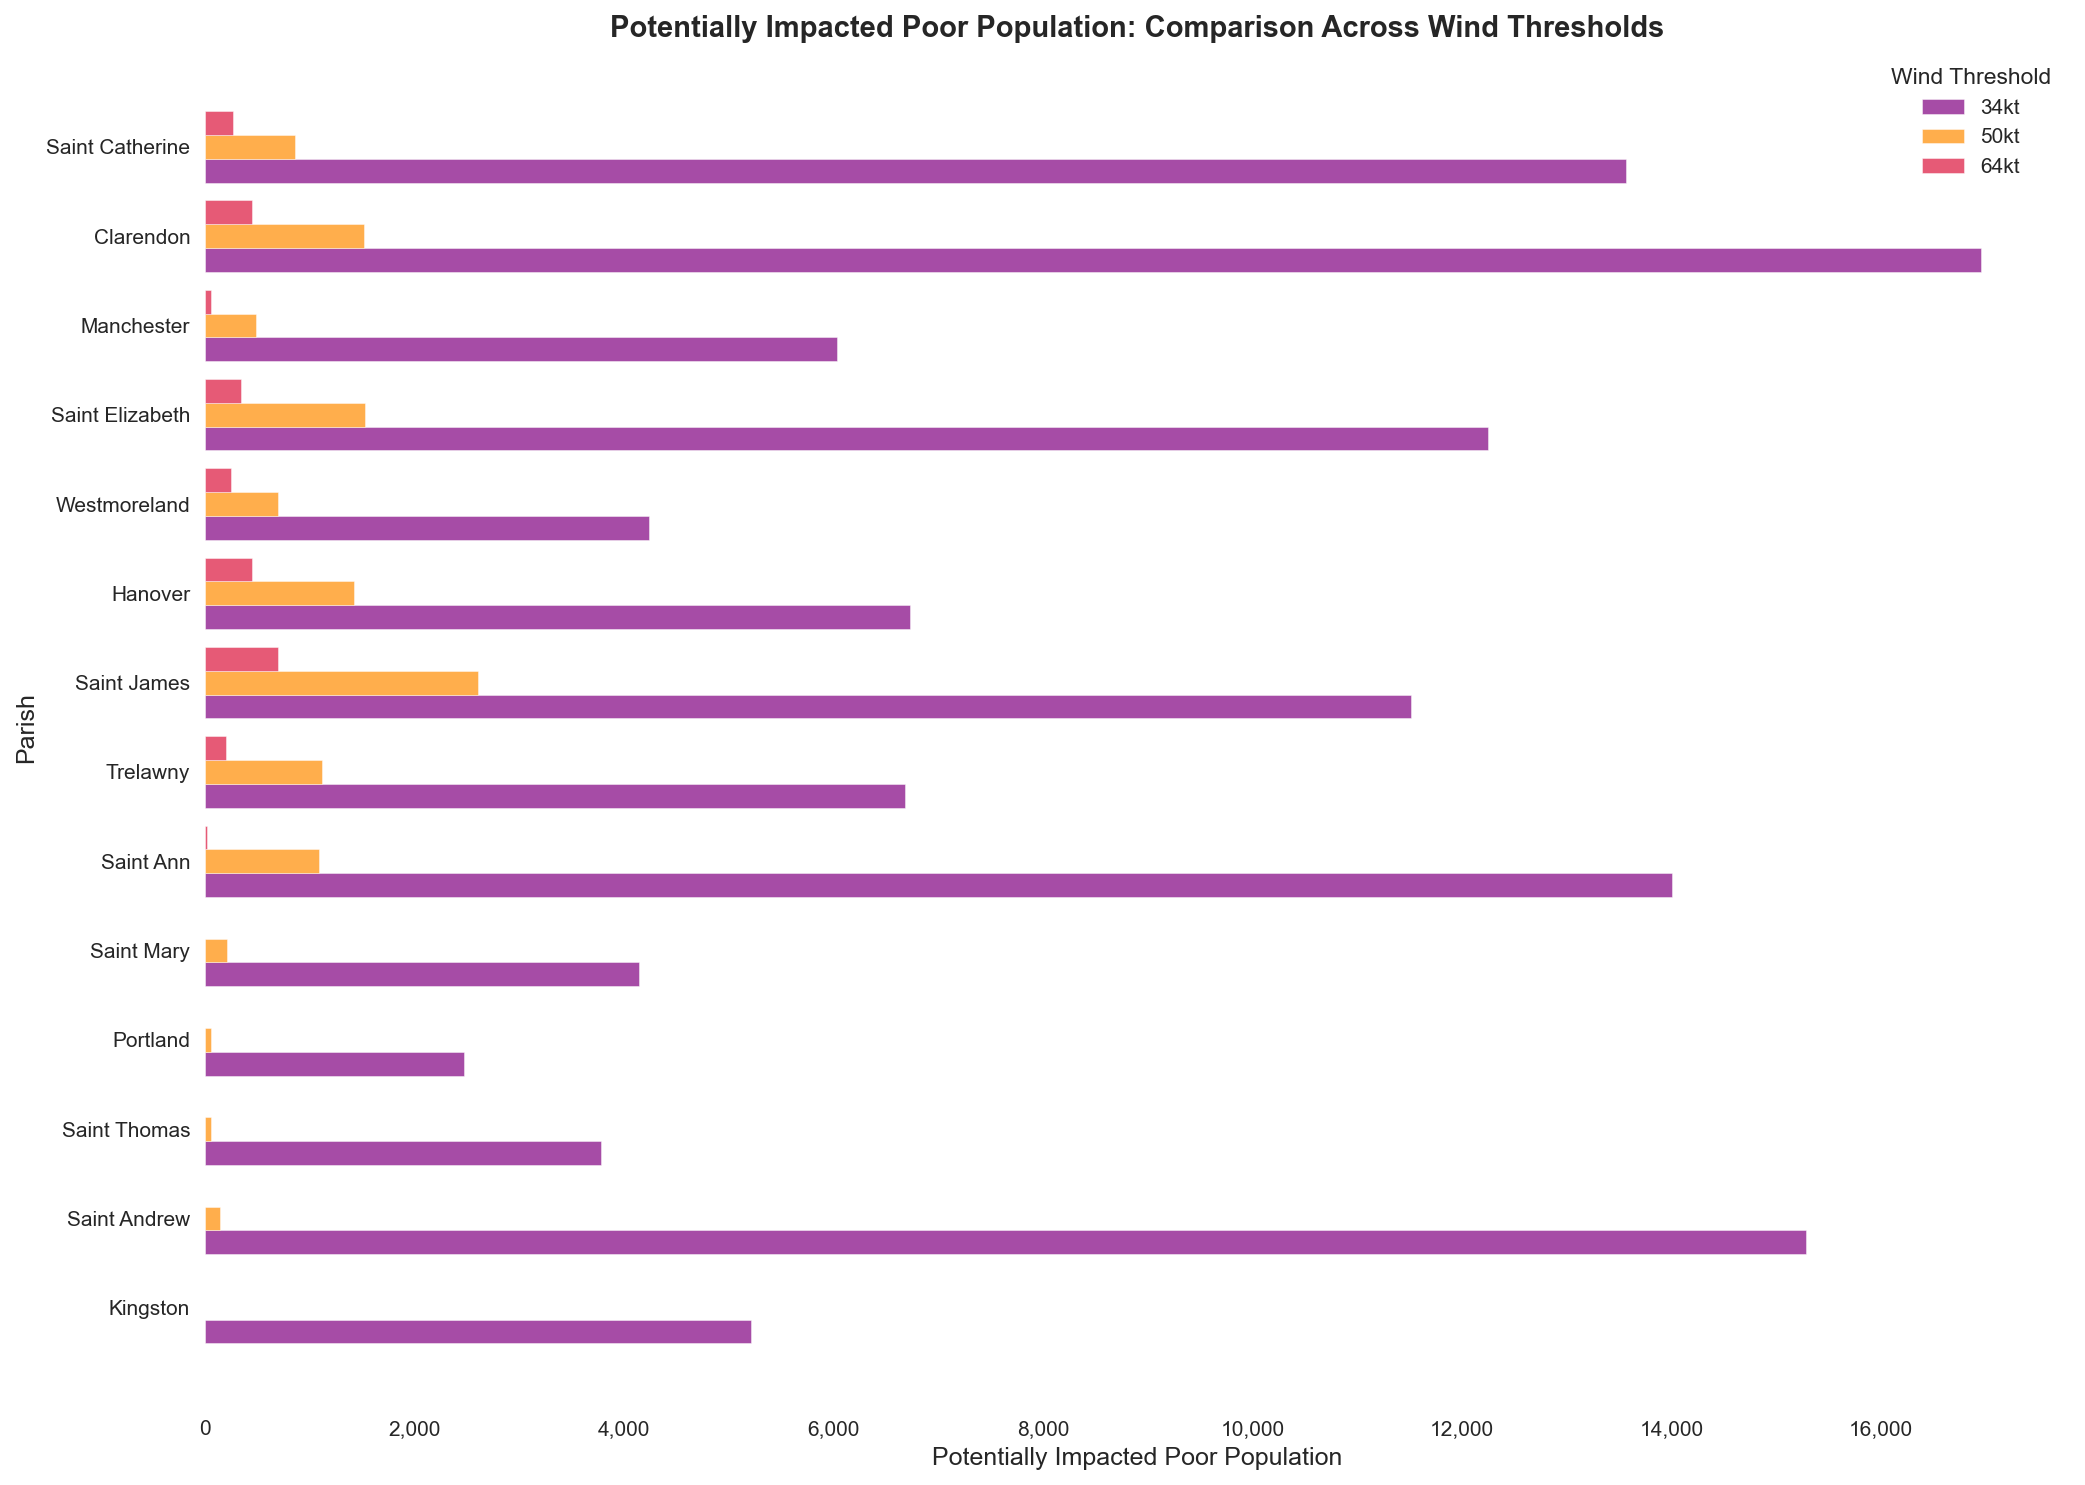

In [145]:
# Create separate visualization for potentially impacted poor population
impact_pop_cols = [col for col in df_summary.columns if col.startswith('potentially_impacted_poor_pop_')]

if impact_pop_cols:
    # Determine layout based on number of thresholds
    n_thresholds = len(impact_pop_cols)
    
    if n_thresholds == 1:
        fig, axes = plt.subplots(1, 1, figsize=(12, 8))
        axes = [axes]
    elif n_thresholds == 2:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    elif n_thresholds == 3:
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    else:
        # For more than 3, use a grid
        n_cols = 3
        n_rows = (n_thresholds + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
        axes = axes.flatten()
    
    # Color palette for different thresholds
    colors = ['purple', 'darkorange', 'crimson', 'teal', 'navy', 'maroon']
    
    for idx, impact_col in enumerate(impact_pop_cols):
        ax = axes[idx]
        threshold = impact_col.replace('potentially_impacted_poor_pop_', '').replace('kt', '')
        
        # Sort by impact population
        df_plot = df_summary.sort_values(impact_col, ascending=True)
        
        # Create horizontal bar chart
        bars = ax.barh(df_plot['parish'], df_plot[impact_col], color=colors[idx % len(colors)], alpha=0.7)
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, df_plot[impact_col])):
            if val > 0:
                ax.text(val, i, f' {val:,.0f}', va='center', fontsize=9)
        
        ax.set_xlabel('Potentially Impacted Poor Population', fontsize=12)
        ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Format x-axis with comma separators
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        # Add total at the top
        total = df_summary[impact_col].sum()
        ax.text(0.98, 0.98, f'Total: {total:,.0f}', 
               transform=ax.transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=11, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_thresholds, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Potentially Impacted Poor Population by Wind Threshold', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Also create a comparison chart showing all thresholds side by side
    print("\nCreating side-by-side comparison...")
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Prepare data for grouped bar chart
    parishes = df_summary['parish'].values
    x = np.arange(len(parishes))
    width = 0.8 / n_thresholds
    
    for idx, impact_col in enumerate(impact_pop_cols):
        threshold = impact_col.replace('potentially_impacted_poor_pop_', '').replace('kt', '')
        values = df_summary[impact_col].values
        offset = (idx - (n_thresholds - 1) / 2) * width
        ax.barh(x + offset, values, width, label=f'{threshold}kt', 
               color=colors[idx % len(colors)], alpha=0.7)
    
    ax.set_xlabel('Potentially Impacted Poor Population', fontsize=12)
    ax.set_ylabel('Parish', fontsize=12)
    ax.set_title('Potentially Impacted Poor Population: Comparison Across Wind Thresholds', 
                fontsize=14, fontweight='bold')
    ax.set_yticks(x)
    ax.set_yticklabels(parishes)
    ax.legend(title='Wind Threshold', fontsize=10, title_fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No impact probability data available for visualization")


## Map Visualizations: Potentially Impacted Poor Population

Spatial distribution of potentially impacted poor population by parish for each wind threshold:


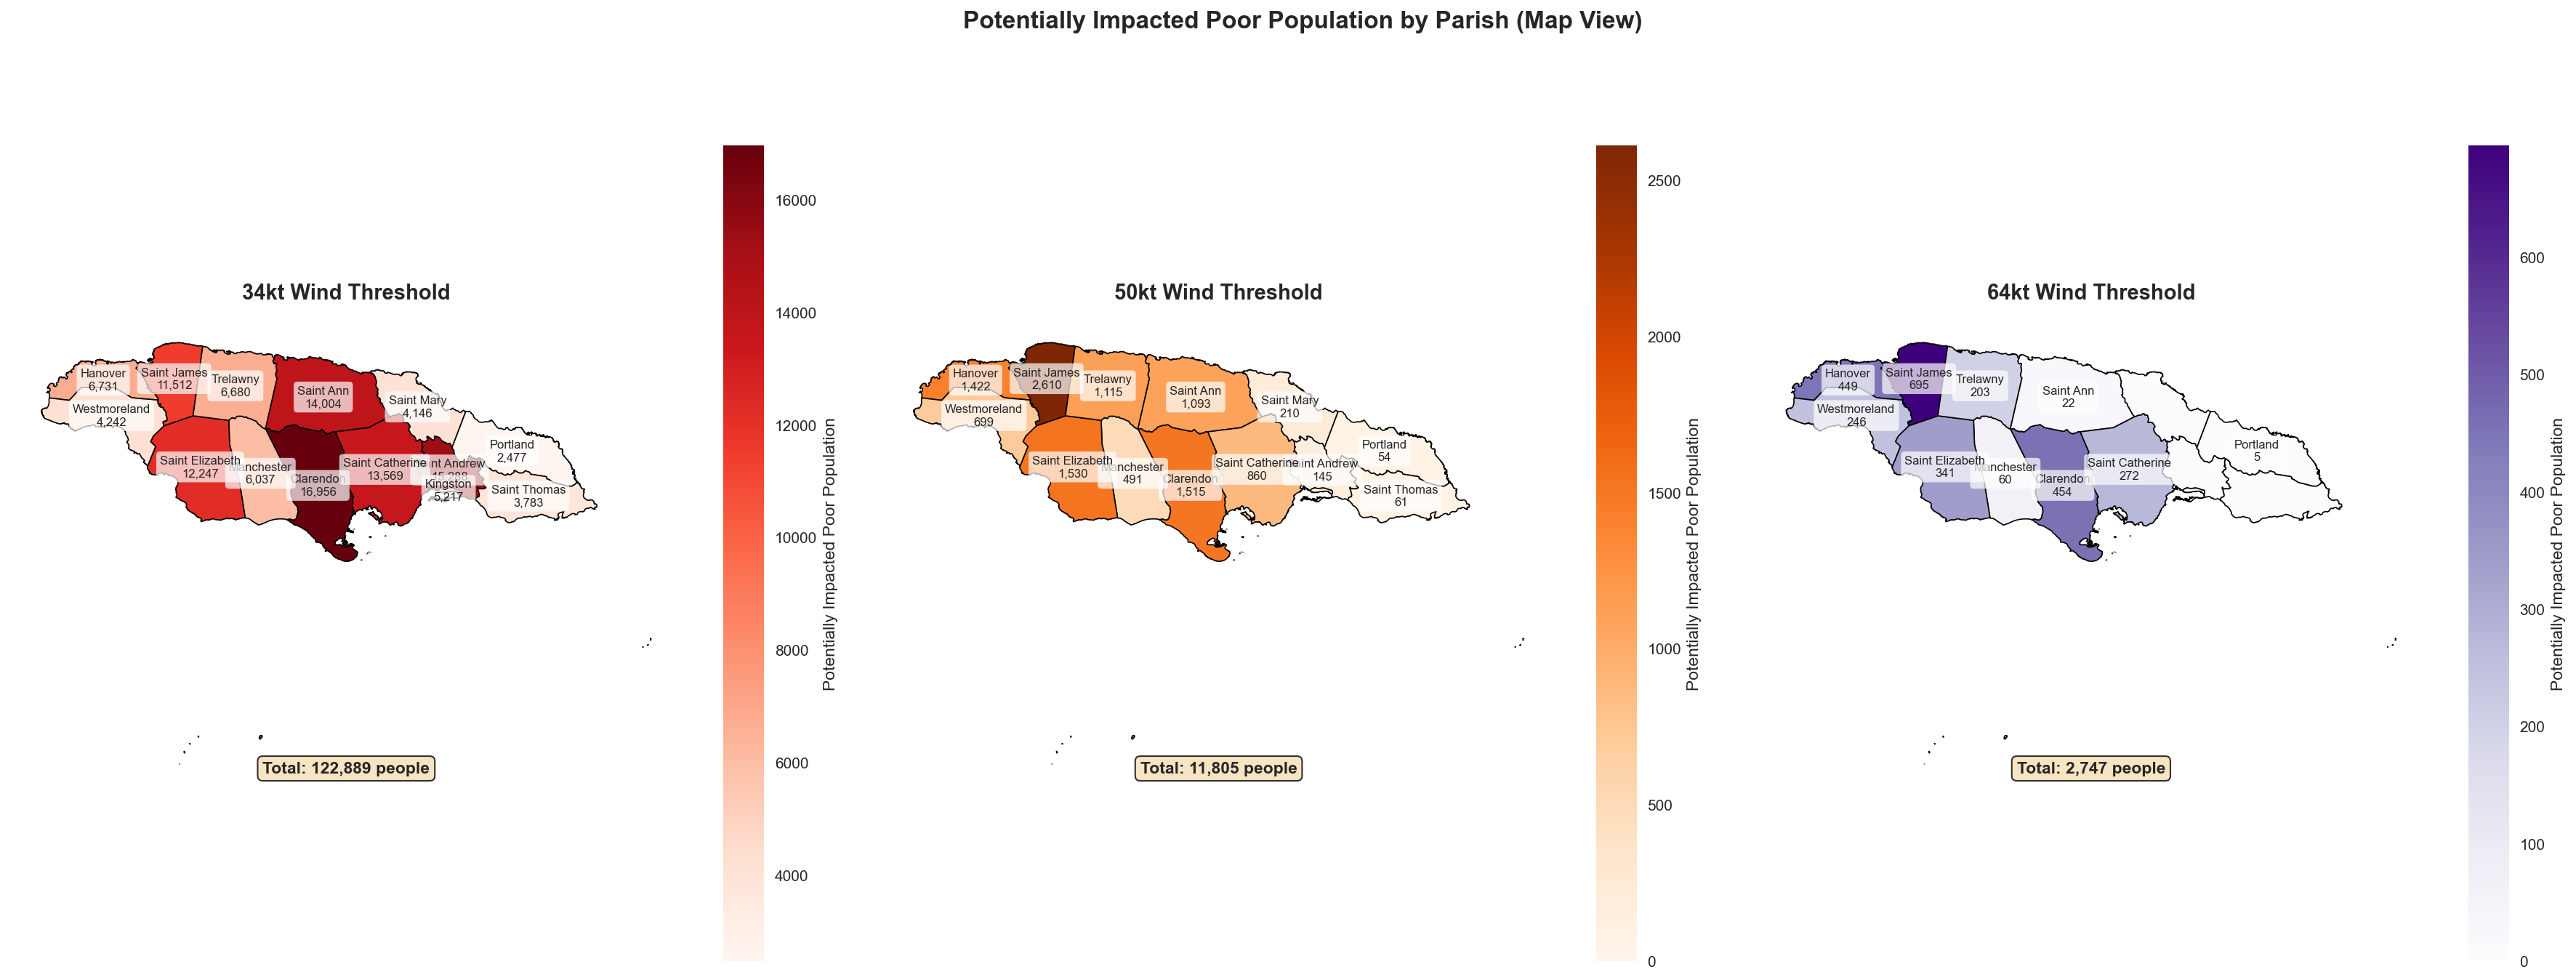

In [146]:
# Create map visualizations for potentially impacted poor population
impact_pop_cols = [col for col in df_summary.columns if col.startswith('potentially_impacted_poor_pop_')]

if impact_pop_cols:
    # Join impact data to admin boundaries for mapping
    gdf_admin_impact = gdf_admin.merge(df_summary, left_on='name', right_on='parish', how='left')
    
    # Determine layout based on number of thresholds
    n_thresholds = len(impact_pop_cols)
    
    if n_thresholds == 1:
        fig, axes = plt.subplots(1, 1, figsize=(12, 10))
        axes = [axes]
    elif n_thresholds == 2:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    elif n_thresholds == 3:
        fig, axes = plt.subplots(1, 3, figsize=(24, 10))
    else:
        # For more than 3, use a grid
        n_cols = 3
        n_rows = (n_thresholds + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 8*n_rows))
        axes = axes.flatten()
    
    # Color palette for different thresholds (using colormaps)
    colormaps = ['Reds', 'Oranges', 'Purples', 'Blues', 'Greens', 'YlOrRd']
    
    for idx, impact_col in enumerate(impact_pop_cols):
        ax = axes[idx]
        threshold = impact_col.replace('potentially_impacted_poor_pop_', '').replace('kt', '')
        
        # Plot admin boundaries colored by potentially impacted poor population
        gdf_admin_impact.plot(
            ax=ax,
            column=impact_col,
            cmap=colormaps[idx % len(colormaps)],
            edgecolor='black',
            linewidth=0.8,
            legend=True,
            legend_kwds={
                'label': 'Potentially Impacted Poor Population',
                'shrink': 0.8
            },
            missing_kwds={
                'color': 'lightgray',
                'edgecolor': 'black',
                'hatch': '///',
                'label': 'No data'
            }
        )
        
        # Format the colorbar labels to show whole numbers (if colorbar exists)
        try:
            fig = ax.get_figure()
            if fig:
                # Find colorbar - it's usually the last axis that's not a subplot
                for cbar_ax in fig.axes:
                    if cbar_ax != ax and hasattr(cbar_ax, 'yaxis'):
                        try:
                            cbar_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
                            break
                        except:
                            pass
        except:
            pass  # If formatting fails, just use default
        
        # Add parish labels
        for idx_parish, row in gdf_admin_impact.iterrows():
            if pd.notna(row[impact_col]) and row[impact_col] > 0:
                centroid = row.geometry.centroid
                ax.text(
                    centroid.x, centroid.y,
                    f"{row['name']}\n{row[impact_col]:,.0f}",
                    ha='center', va='center',
                    fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
                )
        
        ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.axis('off')
        
        # Add total at the bottom
        total = df_summary[impact_col].sum()
        ax.text(0.5, 0.02, f'Total: {total:,.0f} people', 
               transform=ax.transAxes, ha='center', va='bottom',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1),
               fontsize=11, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_thresholds, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Potentially Impacted Poor Population by Parish (Map View)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
else:
    print("No impact probability data available for map visualization")


## Export Results


In [147]:
# Export the results
output_dir = "analysis_output"
os.makedirs(output_dir, exist_ok=True)

# Export poorest cells GeoDataFrame
output_file = os.path.join(output_dir, f"poorest_cells.geojson")
gdf_poorest[gdf_poorest['is_poorest']].to_file(output_file, driver='GeoJSON')
print(f"Exported poorest cells to: {output_file}")

# Export all tiles with poorest flag
all_tiles_file = os.path.join(output_dir, f"all_tiles_with_poorest_flag.parquet")
gdf_poorest.to_parquet(all_tiles_file)
print(f"Exported all tiles to: {all_tiles_file}")

Exported poorest cells to: analysis_output/poorest_cells.geojson
Exported all tiles to: analysis_output/all_tiles_with_poorest_flag.parquet
